In [ ]:
import os
import json
import gzip
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import hdbscan

In [2]:
with open("../dataset/cyberlab_2020-02-29.json") as f:
    data = json.load(f)

In [3]:
events = []
for session in data:
    (session_id, session_events), = session.items()
    for e in session_events:
        e["session_id"] = session_id
        events.append(e)

df = pd.DataFrame(events)
print(df.shape)
df.head()

(379033, 36)


,session_id,dst_host_identifier,eventid,timestamp,src_ip_identifier,dst_ip_identifier,message,protocol,src_port,sensor,...,type,outfile,destfile,duplicate,shasum,url,ttylog,size,filename,data
0,0258c1b64b66,3c84036c67663a493ac99f838e65b00f36c939d90c7814...,cowrie.session.connect,2020-02-29T00:06:51.433806Z,f0bb16e4a6ed33e675e3fdea10ee11afc7f5a9bc57406c...,None,New connection: f0bb16e4a6ed33e675e3fdea10ee11...,ssh,53566.0,ubuntu_basic_pool,...,None,None,None,None,None,None,None,NaN,None,None
1,0258c1b64b66,3c84036c67663a493ac99f838e65b00f36c939d90c7814...,cowrie.client.version,2020-02-29T00:06:51.457121Z,f0bb16e4a6ed33e675e3fdea10ee11afc7f5a9bc57406c...,None,Remote SSH version: b'SSH-2.0-libssh-0.6.3',None,NaN,ubuntu_basic_pool,...,None,None,None,None,None,None,None,NaN,None,None
2,0258c1b64b66,3c84036c67663a493ac99f838e65b00f36c939d90c7814...,cowrie.client.kex,2020-02-29T00:06:51.478455Z,f0bb16e4a6ed33e675e3fdea10ee11afc7f5a9bc57406c...,None,SSH client hassh fingerprint: 51cba57125523ce4...,None,NaN,ubuntu_basic_pool,...,None,None,None,None,None,None,None,NaN,None,None
3,0258c1b64b66,3c84036c67663a493ac99f838e65b00f36c939d90c7814...,cowrie.login.failed,2020-02-29T00:06:51.663160Z,f0bb16e4a6ed33e675e3fdea10ee11afc7f5a9bc57406c...,None,login attempt [root/147258] failed,None,NaN,ubuntu_basic_pool,...,None,None,None,None,None,None,None,NaN,None,None
4,0258c1b64b66,3c84036c67663a493ac99f838e65b00f36c939d90c7814...,cowrie.session.closed,2020-02-29T00:06:52.686702Z,f0bb16e4a6ed33e675e3fdea10ee11afc7f5a9bc57406c...,None,Connection lost after 1 seconds,None,NaN,ubuntu_basic_pool,...,None,None,None,None,None,None,None,NaN,None,None


In [4]:
df.describe(include="all")

,session_id,dst_host_identifier,eventid,timestamp,src_ip_identifier,dst_ip_identifier,message,protocol,src_port,sensor,...,type,outfile,destfile,duplicate,shasum,url,ttylog,size,filename,data
count,379033,379033,379033,379033,379033,0,379033,71172,73292.000000,379033,...,119,0,0,12201,12201,0,12201,12201.000000,0,0
unique,71172,24,10,379033,2783,0,89128,1,NaN,5,...,1,0,0,1,1,0,1,NaN,0,0
top,17ad4067463e,912f523c81eaa22b69e4e40dcd38ff6a50e50a45d2cb13...,cowrie.login.failed,2020-02-29T00:06:51.433806Z,374d2a0a69375cd160fba8a3acd47c6b88c8f819f65405...,NaN,Remote SSH version: b'SSH-2.0-libssh-0.6.3',ssh,NaN,ubuntu_basic_pool,...,ssh-rsa,NaN,NaN,True,e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b93...,NaN,var/lib/cowrie/tty/e3b0c44298fc1c149afbf4c8996...,NaN,NaN,NaN
freq,63,32697,80970,1,17868,NaN,38948,71172,NaN,304581,...,119,NaN,NaN,12201,12201,NaN,12201,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43037.859343,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.027539,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13565.286210,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.710768,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36112.750000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44834.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53400.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,NaN,NaN


ta bort dst_ip_identifier? 0 värden
timestamp --> alla är unika, inga olika tider


In [5]:
for col in df.columns:
    print(col)

session_id
dst_host_identifier
eventid
timestamp
src_ip_identifier
dst_ip_identifier
message
protocol
src_port
sensor
geolocation_data
arch
duration
ssh_client_version
username
password
hasshAlgorithms
macCS
langCS
compCS
encCS
hassh
kexAlgs
keyAlgs
fingerprint
key
type
outfile
destfile
duplicate
shasum
url
ttylog
size
filename
data


In [6]:
print(df['duration'].head)

<bound method NDFrame.head of 0              NaN
1              NaN
2              NaN
3              NaN
4         1.123112
            ...   
379028         NaN
379029         NaN
379030         NaN
379031         NaN
379032    1.656798
Name: duration, Length: 379033, dtype: float64>


In [7]:
df.isna().sum()

session_id                  0
dst_host_identifier         0
eventid                     0
timestamp                   0
src_ip_identifier           0
dst_ip_identifier      379033
message                     0
protocol               307861
src_port               305741
sensor                      0
geolocation_data            0
arch                   379033
duration               299219
ssh_client_version     314428
username               293475
password               293594
hasshAlgorithms        317589
macCS                  317589
langCS                 317589
compCS                 317589
encCS                  317589
hassh                  317589
kexAlgs                317589
keyAlgs                317589
fingerprint            378914
key                    378914
type                   378914
outfile                379033
destfile               379033
duplicate              366832
shasum                 366832
url                    379033
ttylog                 366832
size      

eventid, timestamp, message, sensor, src_ip_identifier --> inga nan värden
dst_ip_identifier, arch, filename, data --> ta bort

In [8]:
# Remove columns with too many missing values
# <30.000 missing values and irrelevant columns for the analysis 

df = df.drop(columns=["dst_ip_identifier", "arch", "hasshAlgorithms", "macCS", "langCS", "compCS", 
    "encCS", "hassh", "kexAlgs", "keyAlgs", "fingerprint", "key", "type",
    "outfile", "destfile", "duplicate", "shasum", "url", "ttylog", "size",
    "filename", "data"])

In [9]:
print(df.columns.tolist())
print(df.shape)

['session_id', 'dst_host_identifier', 'eventid', 'timestamp', 'src_ip_identifier', 'message', 'protocol', 'src_port', 'sensor', 'geolocation_data', 'duration', 'ssh_client_version', 'username', 'password']
(379033, 14)


(Can machine learning models accurately classify attackers into distinct behavioral profiles (automated bots, script kiddies, skilled operators) based on their command sequences and interaction patterns in SSH honeypots?)

Feature Extraction 

Temporal features: inter-command timing, session duration, time-of-day patterns


Command-based features: unique command ratio, command diversity, tool signatures


Behavioral patterns: reconnaissance vs. exploitation ratio, error rate, command correction attempts

In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.sort_values(['session_id', 'timestamp'])

df.head()

,session_id,dst_host_identifier,eventid,timestamp,src_ip_identifier,message,protocol,src_port,sensor,geolocation_data,duration,ssh_client_version,username,password
173403,000122f2cea1,7e3a180ecc937536d7d7a0f2d3539cca6e28be9834d355...,cowrie.session.connect,2020-02-29 11:03:06.852680+00:00,374d2a0a69375cd160fba8a3acd47c6b88c8f819f65405...,New connection: 374d2a0a69375cd160fba8a3acd47c...,ssh,28464.0,ubuntu_basic_pool,"{'continent_code': 'AS', 'country_code3': 'CN'...",NaN,None,None,None
173404,000122f2cea1,7e3a180ecc937536d7d7a0f2d3539cca6e28be9834d355...,cowrie.client.version,2020-02-29 11:03:06.856860+00:00,374d2a0a69375cd160fba8a3acd47c6b88c8f819f65405...,Remote SSH version: b'SSH-2.0-PUTTY',None,NaN,ubuntu_basic_pool,"{'continent_code': 'AS', 'country_code3': 'CN'...",NaN,b'SSH-2.0-PUTTY',None,None
173405,000122f2cea1,7e3a180ecc937536d7d7a0f2d3539cca6e28be9834d355...,cowrie.client.kex,2020-02-29 11:03:07.106306+00:00,374d2a0a69375cd160fba8a3acd47c6b88c8f819f65405...,SSH client hassh fingerprint: 1616c6d18e845e7a...,None,NaN,ubuntu_basic_pool,"{'continent_code': 'AS', 'country_code3': 'CN'...",NaN,None,None,None
173406,000122f2cea1,7e3a180ecc937536d7d7a0f2d3539cca6e28be9834d355...,cowrie.login.failed,2020-02-29 11:03:08.444251+00:00,374d2a0a69375cd160fba8a3acd47c6b88c8f819f65405...,login attempt [root/12345678910] failed,None,NaN,ubuntu_basic_pool,"{'continent_code': 'AS', 'country_code3': 'CN'...",NaN,None,root,12345678910
173407,000122f2cea1,7e3a180ecc937536d7d7a0f2d3539cca6e28be9834d355...,cowrie.login.failed,2020-02-29 11:03:10.914336+00:00,374d2a0a69375cd160fba8a3acd47c6b88c8f819f65405...,login attempt [root/12345678gf] failed,None,NaN,ubuntu_basic_pool,"{'continent_code': 'AS', 'country_code3': 'CN'...",NaN,None,root,12345678gf


In [11]:
df['eventid'].value_counts().head(20)


eventid
cowrie.login.failed            80970
cowrie.session.connect         71172
cowrie.session.closed          67613
cowrie.client.version          64605
cowrie.client.kex              61444
cowrie.command.input           14320
cowrie.log.closed              12201
cowrie.login.success            4469
cowrie.direct-tcpip.request     2120
cowrie.client.fingerprint        119
Name: count, dtype: int64

In [12]:
def extract_command(row):
    msg = row["message"]

    # Only extract for command events
    if row["eventid"] != "cowrie.command.input":
        return np.nan
    
    if not isinstance(msg, str):
        return np.nan
    
    m = msg.lower()

    # Pattern 1: "CMD: <command>"
    if "cmd:" in m:
        return m.split("cmd:")[-1].strip()
    
    # Pattern 2: "input: <command>"
    if "input:" in m:
        return m.split("input:")[-1].strip()
    
    # Pattern 3: bare command (common)
    return m.strip()

df["command"] = df.apply(extract_command, axis=1)


In [13]:
# Inter-command timing
df["inter_command_time"] = df.groupby("session_id")["timestamp"].diff().dt.total_seconds()

# Session duration 
session_times = df.groupby("session_id")["timestamp"].agg(["min", "max"])
session_times["session_duration"] = (session_times["max"] - session_times["min"]).dt.total_seconds()

# Time-of-day
df["hour"] = df["timestamp"].dt.hour
hour_features = df.groupby("session_id")["hour"].agg(
    mean_hour="mean",
    std_hour="std"
)

In [14]:
# #how many commands they typed
# how diverse those commands are
# how “human-like” or “bot-like” their command patterns are

command_features = df.groupby("session_id")["command"].agg(
    total_commands=lambda x: x.notna().sum(),
    unique_commands=lambda x: x.dropna().nunique()
)

command_features["unique_ratio"] = (
    command_features["unique_commands"] /
    command_features["total_commands"].replace(0, np.nan)
)


In [15]:
print(command_features.describe())

       total_commands  unique_commands  unique_ratio
count    71172.000000     71172.000000    858.000000
mean         0.201203         0.200739      0.998648
std          1.919671         1.912155      0.018396
min          0.000000         0.000000      0.692308
25%          0.000000         0.000000      1.000000
50%          0.000000         0.000000      1.000000
75%          0.000000         0.000000      1.000000
max         52.000000        36.000000      1.000000


In [16]:
tools = {
    "wget": "wget",
    "curl": "curl",
    "tftp": "tftp",
    "busybox": "busybox",
    "chmod": "chmod",
    "./": "exec_binary"
}

for tool, pattern in tools.items():
    df[f"tool_{tool}"] = df["message"].str.contains(pattern, case=False, na=False)

tool_features = df.groupby("session_id")[ [f"tool_{t}" for t in tools] ].sum()


In [17]:
print(df['tool_wget'].sum())
print(df['tool_curl'].sum())
print(df['tool_tftp'].sum())
print(df['tool_busybox'].sum()) 
print(df['tool_chmod'].sum())
print(df['tool_./'].sum())      

119
61
65
0
15
0


In [18]:
df.columns.tolist()

['session_id',
 'dst_host_identifier',
 'eventid',
 'timestamp',
 'src_ip_identifier',
 'message',
 'protocol',
 'src_port',
 'sensor',
 'geolocation_data',
 'duration',
 'ssh_client_version',
 'username',
 'password',
 'command',
 'inter_command_time',
 'hour',
 'tool_wget',
 'tool_curl',
 'tool_tftp',
 'tool_busybox',
 'tool_chmod',
 'tool_./']

In [19]:
# Combine all features into final per-session matrix
features = (
    session_times[['session_duration']]
    .join(hour_features, how='left')
    .join(command_features, how='left')
    .join(tool_features, how='left')
)

# Replace NaN with 0 for all non-timing numeric features
features = features.fillna(0)

print(features.head())
print(features.shape)
print(features.columns.tolist())

              session_duration  mean_hour  std_hour  total_commands  \
session_id                                                            
000122f2cea1          6.566378       11.0       0.0               0   
0001bec092c0          6.116296       14.0       0.0               0   
0001cb5ddeaf          2.578426       10.0       0.0               0   
00037bb3edc5          2.783038       23.0       0.0               0   
00060c49f409          3.156416        4.0       0.0               0   

              unique_commands  unique_ratio  tool_wget  tool_curl  tool_tftp  \
session_id                                                                     
000122f2cea1                0           0.0          0          0          0   
0001bec092c0                0           0.0          0          0          0   
0001cb5ddeaf                0           0.0          0          0          0   
00037bb3edc5                0           0.0          0          0          0   
00060c49f409          

In [20]:
features.isna().sum()

session_duration    0
mean_hour           0
std_hour            0
total_commands      0
unique_commands     0
unique_ratio        0
tool_wget           0
tool_curl           0
tool_tftp           0
tool_busybox        0
tool_chmod          0
tool_./             0
dtype: int64

In [21]:
features.describe()

,session_duration,mean_hour,std_hour,total_commands,unique_commands,unique_ratio,tool_wget,tool_curl,tool_tftp,tool_busybox,tool_chmod,tool_./
count,71172.000000,71172.000000,71172.000000,71172.000000,71172.000000,71172.000000,71172.000000,71172.000000,71172.000000,71172.0,71172.000000,71172.0
mean,11.098681,11.622241,0.003023,0.201203,0.200739,0.012039,0.001672,0.000857,0.000913,0.0,0.000211,0.0
std,32.964478,7.147578,0.136665,1.919671,1.912155,0.109005,0.056699,0.029264,0.030207,0.0,0.014516,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
25%,1.895061,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
50%,2.934816,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
75%,5.656439,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
max,1065.288987,23.000000,16.263456,52.000000,36.000000,1.000000,2.000000,1.000000,1.000000,0.0,1.000000,0.0


In [22]:
# Recon command patterns
recon_cmds = ["ls", "pwd", "whoami", "cat", "uname", "id", "ps"]

df["is_recon"] = df["command"].astype(str).str.contains(
    "|".join(recon_cmds),
    case=False,
    na=False
)
recon_features = (
    df.groupby("session_id")["is_recon"]
    .sum()
    .to_frame("recon_count")
)

In [23]:
exploit_cmds = ["wget", "curl", "tftp", "chmod", "busybox", "./"]

df["is_exploit"] = df["command"].astype(str).str.contains(
    "|".join(exploit_cmds),
    case=False,
    na=False
)

exploit_features = (
    df.groupby("session_id")["is_exploit"]
    .sum()
    .to_frame("exploit_count")
)

In [24]:
behavioral_ratio = recon_features.join(exploit_features, how="left")
behavioral_ratio["recon_exploit_ratio"] = (
    behavioral_ratio["recon_count"] /
    behavioral_ratio["exploit_count"].replace(0, np.nan)
)
behavioral_ratio = behavioral_ratio.fillna(0)

In [25]:
print (behavioral_ratio.sum())

recon_count            6857.0
exploit_count          6061.0
recon_exploit_ratio     954.7
dtype: float64


In [26]:
error_patterns = r"permission denied|not found|invalid|error|failed|unknown"

df["is_error"] = df["message"].str.contains(
    error_patterns,
    case=False,
    na=False
)

error_features = (
    df.groupby("session_id")["is_error"]
    .sum()
    .to_frame("error_count")
)


In [27]:
correction_patterns = r"\x08|backspace|command not found|invalid|not found"

df["is_correction"] = df["message"].str.contains(
    correction_patterns,
    case=False,
    na=False
)

correction_features = (
    df.groupby("session_id")["is_correction"]
    .sum()
    .to_frame("correction_count")
)


In [28]:
behavioral_features = (
    behavioral_ratio
    .join(error_features, how="left")
    .join(correction_features, how="left")
)

# Replace missing values with zero
behavioral_features = behavioral_features.fillna(0)

behavioral_features.head()


,recon_count,exploit_count,recon_exploit_ratio,error_count,correction_count
session_id,,,,,
000122f2cea1,0,0,0.0,3,0
0001bec092c0,0,0,0.0,3,0
0001cb5ddeaf,0,0,0.0,1,0
00037bb3edc5,0,0,0.0,1,0
00060c49f409,0,0,0.0,1,0


In [29]:
print(behavioral_features.columns.tolist())

['recon_count', 'exploit_count', 'recon_exploit_ratio', 'error_count', 'correction_count']


In [30]:
behavioral_features.describe()

,recon_count,exploit_count,recon_exploit_ratio,error_count,correction_count
count,71172.000000,71172.000000,71172.000000,71172.000000,71172.0
mean,0.096344,0.085160,0.013414,1.137666,0.0
std,0.917180,0.809597,0.125983,1.046012,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,1.000000,0.0
50%,0.000000,0.000000,0.000000,1.000000,0.0
75%,0.000000,0.000000,0.000000,1.000000,0.0
max,14.000000,13.000000,3.000000,21.000000,0.0


In [31]:
features = (
    session_times[["session_duration"]]
    .join(hour_features, how="left")
    .join(command_features, how="left")
    .join(tool_features, how="left")
    .join(behavioral_features, how="left")
)

features = features.fillna(0)
features.head()


,session_duration,mean_hour,std_hour,total_commands,unique_commands,unique_ratio,tool_wget,tool_curl,tool_tftp,tool_busybox,tool_chmod,tool_./,recon_count,exploit_count,recon_exploit_ratio,error_count,correction_count
session_id,,,,,,,,,,,,,,,,,
000122f2cea1,6.566378,11.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,3,0
0001bec092c0,6.116296,14.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,3,0
0001cb5ddeaf,2.578426,10.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,1,0
00037bb3edc5,2.783038,23.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,1,0
00060c49f409,3.156416,4.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,1,0


In [32]:
timing_stats = df.groupby("session_id")["inter_command_time"].agg(
    mean_inter_command_time="mean",
    median_inter_command_time="median",
    std_inter_command_time="std",
    min_inter_command_time="min",
    max_inter_command_time="max",
).fillna(0) # Fill NaN with 0 for sessions with only one event (no time difference)

# Re-join all features 
features = features.join(timing_stats, how='left').fillna(0)


In [33]:
features.columns.tolist()

['session_duration',
 'mean_hour',
 'std_hour',
 'total_commands',
 'unique_commands',
 'unique_ratio',
 'tool_wget',
 'tool_curl',
 'tool_tftp',
 'tool_busybox',
 'tool_chmod',
 'tool_./',
 'recon_count',
 'exploit_count',
 'recon_exploit_ratio',
 'error_count',
 'correction_count',
 'mean_inter_command_time',
 'median_inter_command_time',
 'std_inter_command_time',
 'min_inter_command_time',
 'max_inter_command_time']

In [34]:
behavior_features = [
 'session_duration',
 'mean_hour',
 'std_hour',
 'total_commands',
 'unique_commands',
 'unique_ratio',
 'tool_wget',
 'tool_curl',
 'tool_tftp',
 'tool_busybox',
 'tool_chmod',
 'tool_./',
 'recon_count',
 'exploit_count',
 'recon_exploit_ratio',
 'error_count',
 'correction_count',
 'mean_inter_command_time',
 'median_inter_command_time',
 'std_inter_command_time',
 'min_inter_command_time',
 'max_inter_command_time'
]

X_cluster = features[behavior_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
features["cluster"] = kmeans.fit_predict(X_scaled)

features["cluster"].value_counts()

cluster
0    68160
2     2997
1       15
Name: count, dtype: int64

In [35]:
cluster_stats_mean = features.groupby("cluster").mean()
cluster_stats_median = features.groupby("cluster").median()
cluster_stats_min = features.groupby("cluster").min()
cluster_stats_max = features.groupby("cluster").max()

print("==== MEAN ====")
display(cluster_stats_mean.T)

print("==== MEDIAN ====")
display(cluster_stats_median.T)

print("==== MIN ====")
display(cluster_stats_min.T)

print("==== MAX ====")
display(cluster_stats_max.T)


==== MEAN ====


cluster,0,1,2
session_duration,5.602010,97.229645,135.676966
mean_hour,11.715103,13.988462,9.498473
std_hour,0.001448,0.025467,0.038740
total_commands,0.185769,15.466667,0.475809
unique_commands,0.185769,13.533333,0.474474
unique_ratio,0.010182,0.943197,0.049614
tool_wget,0.000015,0.666667,0.036036
tool_curl,0.000000,0.533333,0.017684
tool_tftp,0.000954,0.000000,0.000000
tool_busybox,0.000000,0.000000,0.000000


==== MEDIAN ====


cluster,0,1,2
session_duration,2.857803,6.041106,120.138033
mean_hour,12.000000,14.000000,8.000000
std_hour,0.000000,0.000000,0.000000
total_commands,0.000000,23.000000,0.000000
unique_commands,0.000000,16.000000,0.000000
unique_ratio,0.000000,0.960000,0.000000
tool_wget,0.000000,1.000000,0.000000
tool_curl,0.000000,1.000000,0.000000
tool_tftp,0.000000,0.000000,0.000000
tool_busybox,0.000000,0.000000,0.000000


==== MIN ====


cluster,0,1,2
session_duration,0.0,3.956232,65.534272
mean_hour,0.0,10.000000,0.000000
std_hour,0.0,0.000000,0.000000
total_commands,0.0,1.000000,0.000000
unique_commands,0.0,1.000000,0.000000
unique_ratio,0.0,0.692308,0.000000
tool_wget,0.0,0.000000,0.000000
tool_curl,0.0,0.000000,0.000000
tool_tftp,0.0,0.000000,0.000000
tool_busybox,0.0,0.000000,0.000000


==== MAX ====


cluster,0,1,2
session_duration,177.821801,639.923196,1065.288987
mean_hour,23.000000,20.826923,23.000000
std_hour,12.597619,0.382005,16.263456
total_commands,19.000000,52.000000,19.000000
unique_commands,19.000000,36.000000,19.000000
unique_ratio,1.000000,1.000000,1.000000
tool_wget,1.000000,2.000000,2.000000
tool_curl,0.000000,1.000000,1.000000
tool_tftp,1.000000,0.000000,0.000000
tool_busybox,0.000000,0.000000,0.000000


Cluster 0 = BOT

session_duration ≈ 2–6 sek

unique_ratio ≈ 0.00–0.01

total_commands ≈ 0

errors ≈ 1+

mean_inter_command_time ≈ 1s

inga verktyg (wget/curl/chmod = 0)


Cluster 1 = SCRIPT KIDDIE

unique_ratio very high → 0.69–1.00

total_commands high → 23 median, 15 mean

wget/curl/chmod = 1

recon/exploit = 5–6

session_duration ≈ 6–97 sek (median till mean)


Cluster 2 = SKILLED OPERATOR

session_duration very high → 120–135 mean, 65–~1000 range

mean_inter_command_time EXTREME → 113s median

min ICT ≈ 109s

total commands very low (0–1 median)

no wget/curl/chmod

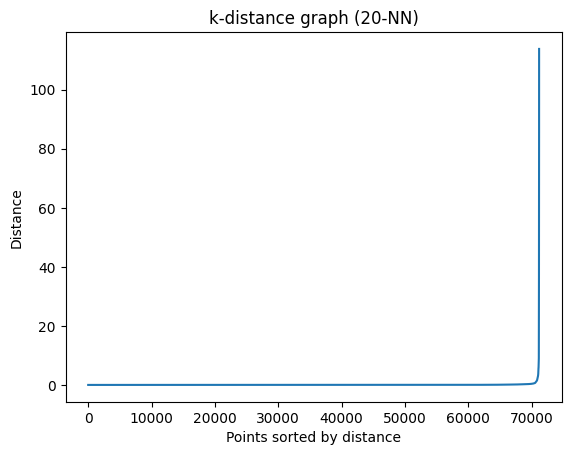

In [ ]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.title("k-distance graph (20-NN)")
plt.ylabel("Distance")
plt.xlabel("Points sorted by distance")
plt.show()


In [ ]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


In [66]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=400,
    min_samples=50,
)

labels = clusterer.fit_predict(X_pca)
features["pca_hdbscan_cluster"] = labels

features["pca_hdbscan_cluster"].value_counts()  

pca_hdbscan_cluster
 16    10331
-1      3678
 1      2627
 11     2228
 9      2161
 7      2131
 10     2050
 48     1882
 8      1786
 42     1760
 38     1739
 32     1726
 39     1682
 34     1668
 45     1656
 33     1645
 47     1643
 46     1601
 15     1598
 41     1592
 40     1538
 35     1511
 43     1500
 44     1347
 37     1318
 31     1260
 36     1222
 50     1159
 29      818
 0       717
 5       656
 4       616
 6       609
 20      599
 3       585
 28      580
 12      570
 27      561
 2       551
 19      546
 22      529
 17      528
 13      523
 25      496
 21      489
 14      484
 23      479
 26      465
 18      456
 24      448
 30      427
 49      401
Name: count, dtype: int64

Text(0, 0.5, 'Cumulative explained variance')

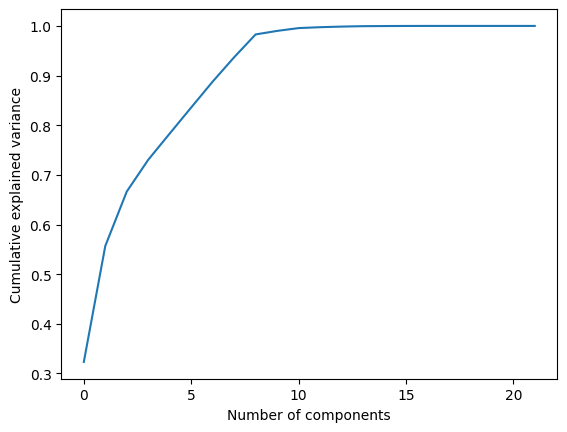

In [62]:
pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")

In [65]:
features.groupby("pca_hdbscan_cluster")[behavior_features].mean()


,session_duration,mean_hour,std_hour,total_commands,unique_commands,unique_ratio,tool_wget,tool_curl,tool_tftp,tool_busybox,...,recon_count,exploit_count,recon_exploit_ratio,error_count,correction_count,mean_inter_command_time,median_inter_command_time,std_inter_command_time,min_inter_command_time,max_inter_command_time
pca_hdbscan_cluster,,,,,,,,,,,,,,,,,,,,,
-1,44.140475,10.970382,0.057366,0.386623,0.377651,0.038021,0.032355,0.016585,0.017673,0.0,...,0.180261,0.172920,0.033259,1.283034,0.0,12.029107,8.062157,13.446296,3.468849,32.088333
0,49.166706,11.959700,0.005845,17.988842,17.988842,1.000000,0.000000,0.000000,0.000000,0.0,...,8.638773,7.566248,1.160914,0.000000,0.0,3.045693,4.537865,3.180702,0.181141,9.889230
1,120.111302,9.323182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,120.111302,120.111302,0.000000,120.111302,120.111302
2,5.164317,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,3.000000,0.0,0.860720,1.200811,0.578555,0.004569,1.271394
3,5.225804,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,3.000000,0.0,0.870967,1.204829,0.588229,0.004386,1.313124
4,5.206283,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,3.000000,0.0,0.867714,1.206176,0.583626,0.004880,1.297008
5,5.227418,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,3.000000,0.0,0.871236,1.206486,0.590276,0.004455,1.320340
6,5.229808,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,3.000000,0.0,0.871848,1.209676,0.591907,0.004676,1.323313
7,2.500051,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,1.000000,0.0,0.625013,0.514210,0.558385,0.163054,1.308577


In [147]:
def map_attacker_type(cluster):
    # Skilled attackers
    if cluster == -1:
        return "skilled operator"
    
    # Script kiddie: tool-based scanning, many unique commands
    if cluster == 0:
        return "script kiddie"
    
    # All automated behavior 
    return "bot"



In [148]:
features["behavior_label"] = features["pca_hdbscan_cluster"].apply(map_attacker_type)


In [149]:
features["behavior_label"].value_counts()


behavior_label
bot                 66777
skilled operator     3678
script kiddie         717
Name: count, dtype: int64

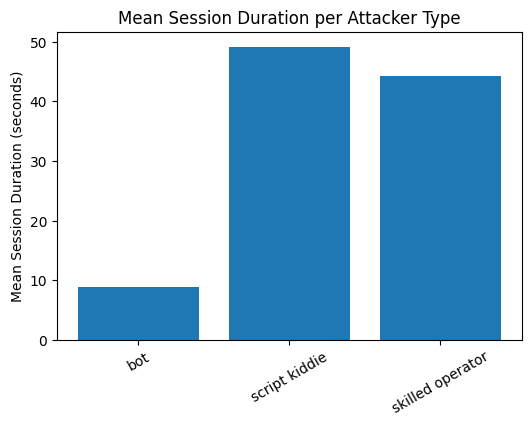

In [150]:
mean_duration = features.groupby("behavior_label")["session_duration"].mean()

plt.figure(figsize=(6,4))
plt.bar(mean_duration.index, mean_duration.values)
plt.title("Mean Session Duration per Attacker Type")
plt.ylabel("Mean Session Duration (seconds)")
plt.xticks(rotation=30)
plt.show()


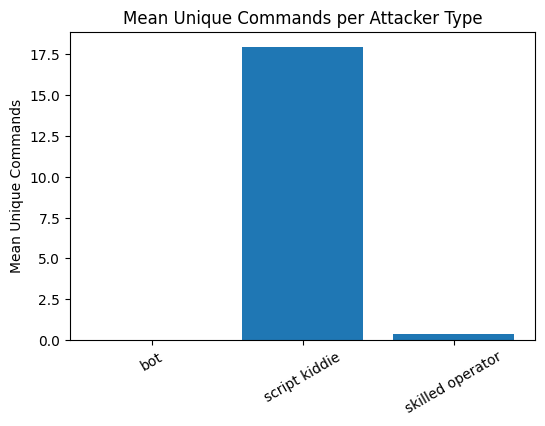

In [151]:
unique_cmds = features.groupby("behavior_label")["unique_commands"].mean()

plt.figure(figsize=(6,4))
plt.bar(unique_cmds.index, unique_cmds.values)
plt.title("Mean Unique Commands per Attacker Type")
plt.ylabel("Mean Unique Commands")
plt.xticks(rotation=30)
plt.show()


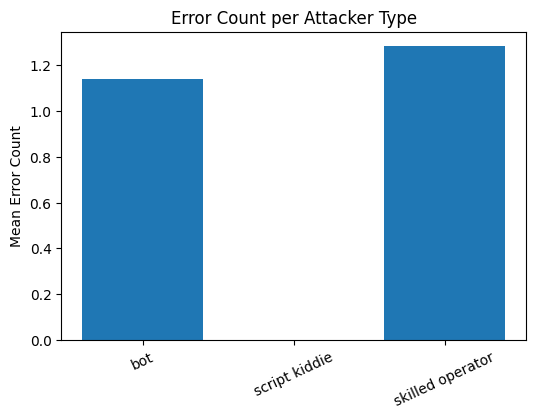

In [152]:
err = features.groupby("behavior_label")["error_count"].mean()

plt.figure(figsize=(6,4))
plt.bar(err.index, err.values)
plt.ylabel("Mean Error Count")
plt.title("Error Count per Attacker Type")
plt.xticks(rotation=25)
plt.show()


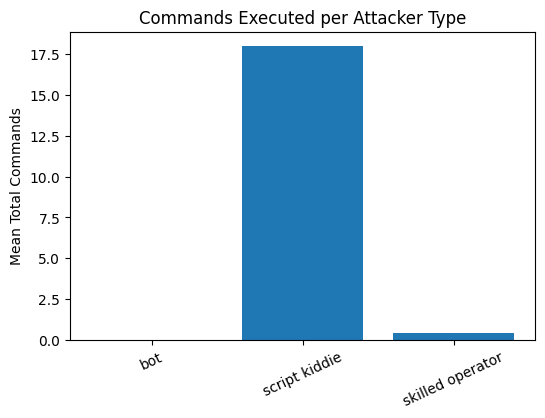

In [153]:
cmds = features.groupby("behavior_label")["total_commands"].mean()

plt.figure(figsize=(6,4))
plt.bar(cmds.index, cmds.values)
plt.ylabel("Mean Total Commands")
plt.title("Commands Executed per Attacker Type")
plt.xticks(rotation=25)
plt.show()


In [ ]:
uniq = features.groupby("behavior_label")["unique_commands"].mean()
uniq.plot(kind="bar")


NameError: name 'features' is not defined

In [154]:
X = features[behavior_features]        
y = features["behavior_label"]            

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


                  precision    recall  f1-score   support

             bot       1.00      1.00      1.00     13356
   script kiddie       1.00      1.00      1.00       143
skilled operator       0.97      0.93      0.95       736

        accuracy                           0.99     14235
       macro avg       0.99      0.97      0.98     14235
    weighted avg       0.99      0.99      0.99     14235

[[13336     0    20]
 [    0   143     0]
 [   55     0   681]]


In [ ]:
importances = rf.feature_importances_
feat_imp = pd.DataFrame({
    "feature": behavior_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp


,feature,importance
14,recon_exploit_ratio,0.129575
1,mean_hour,0.123414
0,session_duration,0.099880
4,unique_commands,0.095544
12,recon_count,0.080044
21,max_inter_command_time,0.070525
3,total_commands,0.066690
19,std_inter_command_time,0.064940
17,mean_inter_command_time,0.056106
13,exploit_count,0.051928


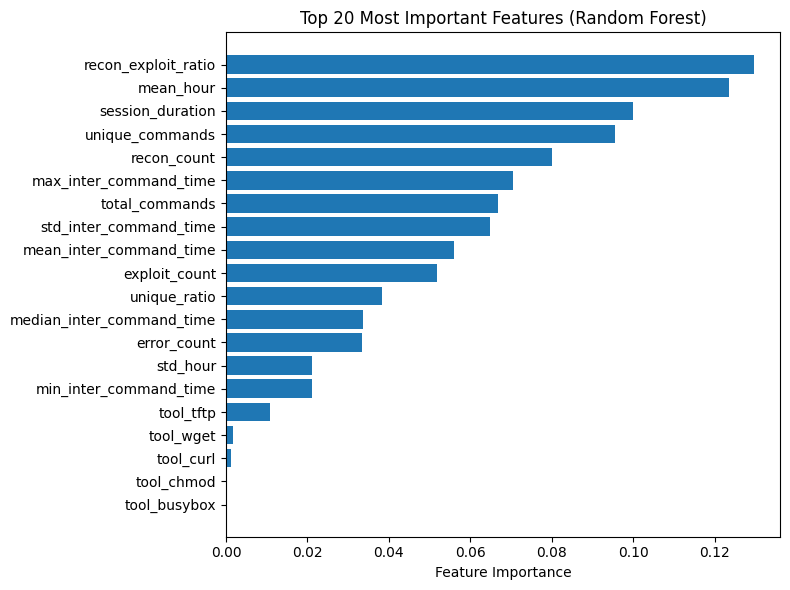

In [ ]:
top_n = 20
top_features = feat_imp.head(top_n)

plt.figure(figsize=(8,6))
plt.barh(top_features["feature"], top_features["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()
